# SmartSifter

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rd
import itertools
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as st

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import matplotlib.animation as ani
from IPython.display import display
plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]
%matplotlib inline

## SDLEアルゴリズム

In [2]:
#データ生成(離散値ベクトル)
rd.seed(0)
T = 500 #データ数(観測数)
x_1 = np.array([np.argmax(i) for i in rd.multinomial(1, [1/6]*6,T)])
x_2 = rd.binomial(1, 0.5, T)
x = np.c_[x_1, x_2]

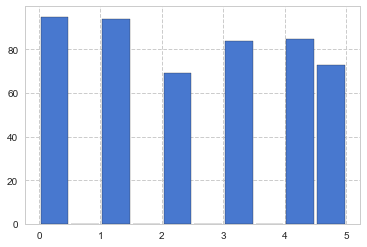

In [3]:
plt.hist(x_1, rwidth=0.9)
plt.show()

In [4]:
class SDLE:
    def __init__(self, r, beta, A):
        """
        """
        #Given
        self.A = A #セルの分割全体
        self.r = r #忘却係数 
        self.beta = beta #正の定数
        
        
        #パラメータの初期化
        self.M = len(A) #セルの数
        self.A_det = np.zeros(self.M) #各セルに含まれた観測データ数格納用
        self.t = 1
        self.T_t = np.zeros(self.M) #各セルの統計量の計数
        self.prob = np.zeros(self.M)
        self.flag = None #更新の行われたセル番号を格納
    
    def update(self, x_t):
        """
        オンライン学習
        """
        if isinstance(x_t, np.int64):
            x_t = np.array([x_t]) #1次元ベクトルを対応させる
        
        #T_t, probに1行追加
        new_index = np.zeros(self.M)
        if self.t == 1:
            self.T_t = np.concatenate([self.T_t[:,np.newaxis].T, new_index[:,np.newaxis].T])
            self.prob = np.concatenate([self.prob[:,np.newaxis].T, new_index[:,np.newaxis].T])
        
        else:
            self.T_t = np.concatenate([self.T_t, new_index[:,np.newaxis].T])
            self.prob = np.concatenate([self.prob, new_index[:,np.newaxis].T])
        
        for i, A_m in enumerate(self.A):
            delta = 0
            if np.array_equal(x_t, np.array(A_m)):
                delta = 1
                self.A_det[i] += 1
                self.flag = x_t
            
            self.T_t[self.t, i] = (1-self.r) * self.T_t[self.t-1,i] + delta
            if self.r == 0:
                q = (self.T_t[self.t, i] + self.beta) / (self.t + self.M * self.beta)
            else:
                q = (self.T_t[self.t, i]+self.beta) / ((1 - (1-self.r)**self.t)/self.r + self.M*self.beta)
            
            if not self.A_det[i] == 0:
                self.prob[self.t, i] = q / self.A_det[i]
        
        self.t += 1
    
    def train(self, x):
        """
        バッチ学習
        """
        T = len(x) #データ数(観測数)
        while self.t <= T:
            self.update(x[self.t-1])

In [5]:
# A = list(itertools.product(set(x_1), set(x_2)))
x = x_1.copy()
A = list(itertools.product(set(x)))
r = 1 / len(x) #忘却パラメータ
beta = 1 #正の定数

sdle = SDLE(r, beta, A)

In [6]:
sdle.train(x)
sdle.prob

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.28571429],
       [ 0.        ,  0.        ,  0.25006252,  0.        ,  0.        ,
         0.24981245],
       ..., 
       [ 0.00208236,  0.00201122,  0.00212768,  0.00191246,  0.00196691,
         0.00195242],
       [ 0.00207588,  0.00200497,  0.00212108,  0.00190652,  0.00197428,
         0.00194636],
       [ 0.00208031,  0.00199874,  0.00211451,  0.0019006 ,  0.00196815,
         0.00194034]])

In [7]:
p = sdle.prob[-1] * (1/sdle.prob[-1].sum())
p

array([ 0.17332087,  0.16652454,  0.17617046,  0.15834872,  0.16397636,
        0.16165904])

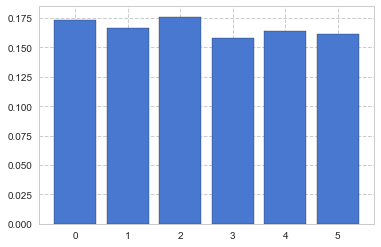

In [8]:
plt.bar(range(len(A)), p)
plt.show()

## SDEMアルゴリズム

check:  0 [ 0.2  0.5] [[ 0.1    0.085]
 [ 0.085  0.1  ]] 0.002775
check:  1 [ 1.2  0.5] [[ 0.1   -0.085]
 [-0.085  0.1  ]] 0.002775
check:  2 [ 2.   0.5] [[ 0.1    0.085]
 [ 0.085  0.1  ]] 0.002775


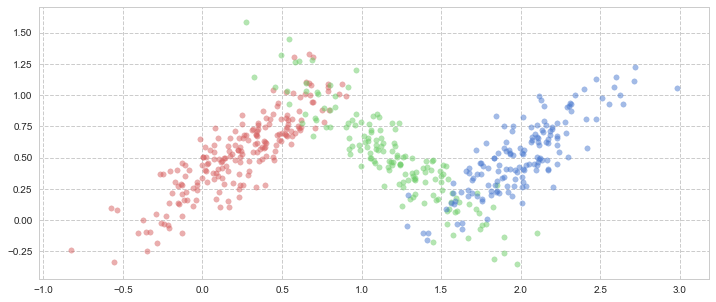

In [9]:
seed = 77
D = 2
n = [200, 150, 150]
N = np.sum(n)
mu_true = np.asanyarray(
     [[0.2, 0.5],
      [1.2, 0.5],
      [2.0, 0.5]])

D = mu_true.shape[1]

sigma_true = np.asanyarray(
        [ [[0.1,  0.085],[ 0.085, 0.1]],
          [[0.1, -0.085],[-0.085, 0.1]],
          [[0.1,  0.085],[ 0.085, 0.1]]
        ])
c = ['r', 'g', 'b']

rd.seed(seed)
org_data = None #np.empty((np.sum(n), 3))
for i in range(3):
    print("check: ", i, mu_true[i], sigma_true[i], np.linalg.det(sigma_true[i]))
    #org_data.append(st.multivariate_normal.rvs(mean=mu[i], cov=sigma[i], size=n[i]))
    if org_data is None:
        org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
    else:
        org_data = np.r_[org_data, np.c_[st.multivariate_normal.rvs(mean=mu_true[i], 
                                                                    cov=sigma_true[i], 
                                                                    size=n[i]), np.ones(n[i])*i]]
        
# plot generated data        
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c=c[i], alpha=0.5)
    
# drop true cluster label
data = org_data[:,0:2].copy()

In [10]:
class SDEM:
    def __init__(self, r, alpha, k, d):
        """
        パラメータの初期化
        """
        self.r = r
        self.alpha = alpha
        self.k = k
        self.d = d
        
        self.prob = np.zeros((1, self.k))
        self.mu = np.zeros((1, self.k, self.d))
        self.mu_ = np.zeros((1, self.k, self.d))
        self.pi = np.zeros((1, self.k))
        self.sigma = np.zeros((1, self.k, self.d, self.d))
        self.sigma_ = np.zeros((1, self.k, self.d, self.d))
        
        for i in range(self.k):
            self.pi[0, i] = 1 / self.k #piの初期化
            self.mu[0, i] = rd.uniform(low=0, high=1, size=self.d) #muの初期化(一様分布)
            self.mu_[0, i] = self.mu[0, i] * self.pi[0, i] #mu_の初期化(mu*piで計算)
            self.sigma[0, i] = np.identity(self.d) #sigmaの初期化(単位行列)
            self.sigma_[0, i] = (self.sigma[0, i] + np.dot(self.mu[0, i][:,np.newaxis], self.mu[0, i][:,np.newaxis].T)) * self.pi[0, i] #sigma_初期化

        self.t = 1
    
    def calc_prob(self, y_t, pi, mu, sigma):
        """
        t時点のパラメータを使用し確率値の計算
        """
        p = np.zeros(self.k)
        for i in range(self.k):
            p[i] = st.multivariate_normal.pdf(y_t, mu[i], sigma[i])
        return p
        
    #E-Step
    def E_step(self, y_t, t):
        """Eステップ(負担率gammaから各パラメータ_とpiを求める)"""

        #pi*p(y|mu,sigma)を計算する
        pi_prob = np.array([self.pi[t-1, i]*st.multivariate_normal.pdf(y_t, self.mu[t-1,i], self.sigma[t-1, i]) for i in range(self.k)])
        gamma = (1 - self.alpha * self.r) * pi_prob / np.sum(pi_prob) + (self.alpha * self.r / self.k)
        #piを計算する
        self.pi[t] = (1 - self.r) * self.pi[self.t-1] + self.r * gamma
        #mu_を計算する
        self.mu_[t] = (1 - self.r)*self.mu_[t-1] + self.r * gamma[:, np.newaxis] * y_t
        #sigma_を計算する
        for i in range(k):
            self.sigma_[t, i] = (1 - self.r) * self.sigma_[t-1, i] + self.r * gamma[i] * np.dot(y_t[:, np.newaxis], y_t[:, np.newaxis].T)

    #M-Step
    def M_step(self, y_t, t):
        """Mステップ(gammaを使って、各パラメータを更新する)"""
        #muを計算する
        self.mu[t] = self.mu_[t] / self.pi[t][:, np.newaxis]
        #sigmaを計算する
        for i in range(self.k):
            self.sigma[t, i] = self.sigma_[t, i] / self.pi[t, i] - np.dot(self.mu[t, i][:, np.newaxis], self.mu[t, i][:, np.newaxis].T)
    
    def update(self, y_t):
        """
        """
        #pi, mu, mu_, sigma, sigma_, probに1行追加
        prob_tmp = np.zeros((1, self.k))
        pi_tmp = np.zeros((1, self.k))
        mu_tmp = np.zeros((1, self.k, self.d))
        sigma_tmp = np.zeros((1, self.k, self.d, self.d))

        self.prob = np.concatenate([self.prob, prob_tmp])
        self.pi = np.concatenate([self.pi, pi_tmp])
        self.mu = np.concatenate([self.mu, mu_tmp])
        self.mu_ = np.concatenate([self.mu_, mu_tmp])
        self.sigma = np.concatenate([self.sigma, sigma_tmp])
        self.sigma_ = np.concatenate([self.sigma_, sigma_tmp])
        #E-step
        self.E_step(y_t, self.t)
        #M-Step
        self.M_step(y_t, self.t)
        
        self.prob[self.t] = self.calc_prob(y_t, self.pi[self.t], self.mu[self.t], self.sigma[self.t])
            
        self.t += 1
    
    def skip(self):
        """"""
        #pi, mu, mu_, sigma, sigma_, probに1行追加
        prob_tmp = np.zeros((1, self.k))
        pi_tmp = np.zeros((1, self.k))
        mu_tmp = np.zeros((1, self.k, self.d))
        sigma_tmp = np.zeros((1, self.k, self.d, self.d))

        if self.t == 1:
            self.prob = np.concatenate([self.prob, prob_tmp])
            self.pi = np.concatenate([self.pi, pi_tmp])
            self.mu = np.concatenate([self.mu, mu_tmp])
            self.mu_ = np.concatenate([self.mu_, mu_tmp])
            self.sigma = np.concatenate([self.sigma, sigma_tmp])
            self.sigma_ = np.concatenate([self.sigma_, sigma_tmp])
        else:
            self.prob = np.concatenate([self.prob, prob_tmp])
            self.pi = np.concatenate([self.pi, pi_tmp])
            self.mu = np.concatenate([self.mu, mu_tmp])
            self.mu_ = np.concatenate([self.mu_, mu_tmp])
            self.sigma = np.concatenate([self.sigma, sigma_tmp])
            self.sigma_ = np.concatenate([self.sigma_, sigma_tmp])
        # 更新をしない
        for i in range(self.k):
            self.pi[self.t, i] = self.pi[self.t-1, i]
            self.mu[self.t, i] = self.mu[self.t-1, i]
            self.mu_[self.t, i] = self.mu_[self.t-1, i]
            self.sigma[self.t, i] = self.sigma[self.t-1, i]
            self.sigma_[self.t, i] = self.sigma_[self.t-1, i]
            self.prob[self.t] = self.prob[self.t-i, i]
        self.t += 1
    
    def train(self, y):
        """
        バッチ学習
        """
        T = len(y) #データ数(観測数)
        while self.t < T:
            self.update(y[self.t-1])

In [11]:
alpha = 1.0
k = 3
T = data.shape[0]
d = data.shape[1]
r = 1/T

sdem = SDEM(r, alpha, k, d)
sdem.prob

array([[ 0.,  0.,  0.]])

In [12]:
sdem.train(data)

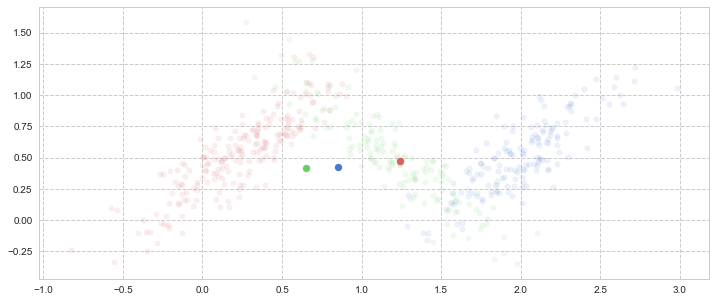

In [13]:
# plot generated data        
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c=c[i], alpha=0.1)
#c_ = ["c", "m", "y"]
for i in range(3):
    plt.scatter(sdem.mu[-1, i, 0], sdem.mu[-1, i, 1], s=50, c=c[i])

In [14]:
def hellinger_distance(mu, sigma, mu_prev, sigma_prev):
    mu = mu.reshape((mu.shape[0], 1))
    mu_prev = mu_prev.reshape((mu_prev.shape[0], 1))
    
    d_h = -(2 * np.linalg.det((np.linalg.inv(sigma) + np.linalg.inv(sigma_prev)) / 2) ** (-1/2)) / (np.linalg.det(sigma) ** (1/4) * np.linalg.det(sigma_prev) ** (1/4))
    
    #tmp = np.exp((1/2) * np.dot(np.dot(np.dot(np.linalg.inv(sigma), mu) + np.dot(np.linalg.inv(sigma_prev), mu_prev).T, 
    #                          np.linalg.inv(np.linalg.inv(sigma) + np.linalg.inv(sigma_prev))),
    #                          np.dot(np.linalg.inv(sigma), mu + np.dot(np.linalg.inv(sigma_prev), mu_prev).T)))
    A = (np.dot(np.linalg.inv(sigma), mu) + np.dot(np.linalg.inv(sigma_prev), mu_prev)).T
    B = np.linalg.inv(np.linalg.inv(sigma) + np.linalg.inv(sigma_prev))
    C = np.dot(np.linalg.inv(sigma), mu) + np.dot(np.linalg.inv(sigma_prev), mu_prev)
    
    #print("A", A)
    #print("B", B)
    #print("C", C)
    tmp = np.exp((1/2) * np.dot(np.dot(A, B), C))
    tmp *= np.exp(-(1/2) * (np.dot(np.dot(mu.T, np.linalg.inv(sigma)), mu) + np.dot(np.dot(mu_prev.T, np.linalg.inv(sigma_prev)), mu_prev)))
    d_h *= tmp
    d_h += 2
    return d_h

def calc_hellinger_distance(pi, pi_prev, mu, sigma, mu_prev, sigma_prev, k):
    d_H = 0
    for i in range(k):
        d_h = hellinger_distance(mu[i], sigma[i], mu_prev[i], sigma_prev[i])
        d_H += (pi[i] + pi_prev[i])/2 * d_h
    tmp = 0
    for i in range(k):
        tmp += np.sqrt(pi[i]) - np.sqrt(pi_prev[i]) ** 2
    d_H += tmp 
    return d_H

def calc_hellinger_score(p, p_prev, sdem, r, k, M):
    S_H = 0
    for m in range(M):
        d_H = calc_hellinger_distance(sdem[m].pi[sdem[m].t-1], sdem[m].pi[sdem[m].t-2] ,sdem[m].mu[sdem[m].t-1],
                                      sdem[m].sigma[sdem[m].t-1], sdem[m].mu[sdem[m].t-2], sdem[m].sigma[sdem[m].t-2], k)
        S_H += np.sqrt(p[m] * p_prev[m]) * d_H
    tmp = 0
    for m in range(M):
        tmp += np.sqrt(p[m] * p_prev[m])
    tmp *= 2
    S_H += 2 - tmp
    S_H /= r**2
    
    return S_H

In [15]:
x = x.reshape((500, 1))
y = data.copy()
Z = np.concatenate((x, y), axis=1)
Z = Z
# x
# X[:, 0]
# y
# X[:, 1:]

### SmartSifterの実行

In [16]:
# パラメータ設定
alpha = 1.0
k = 3
T = data.shape[0]
d = data.shape[1]
r = 1/T * 100
beta = 1
M = len(np.unique(x))

# オブジェクトの初期化
sdle = SDLE(r, beta, A)
sdem = [SDEM(r, alpha, k, d) for i in range(M)]

# 同時確率
p = []
# ヘリンジャースコア
S_H = []
# 対数損失
S_L = []

In [17]:
for i, (x_t, y_t) in enumerate(zip(x, y)):
    sdle.update(x_t)
    # 各セルに対応する混合ガウス分布を推定
    for m in range(sdle.M):
        if sdle.flag == None:
            sdem[m].skip()
        elif m == int(sdle.flag):
            sdem[m].update(y_t)
        else:
            sdem[m].skip()
        # tmp: p(y|x)
        tmp = np.dot(sdem[m].prob[sdem[m].t-1], sdem[m].pi[sdem[m].t-1])
    if i == 0:
        p_prev = 0
    else:
        p_prev = p[-1]  
    p_t = tmp * sdle.prob[sdle.t-1, int(sdle.flag)]
    p.append(p_t)
    s_h = calc_hellinger_score(sdle.prob[sdle.t-1], sdle.prob[sdle.t-2], sdem, sdle.r, k, sdle.M)
    S_H.append(float(s_h))
    s_l = -np.log(p_prev)
    S_L.append(s_l)

/Users/satetsu/anaconda/envs/datamining/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  """
/Users/satetsu/anaconda/envs/datamining/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


In [18]:
df = pd.DataFrame(Z)
df.columns = ["x", "y1", "y2"]
df_S_L = pd.DataFrame(S_L)
df_S_H = pd.DataFrame(S_H)
df_S_L.columns = ["S_L"]
df_S_H.columns = ["S_H"]
df = pd.concat([df, df_S_L, df_S_H], axis=1)
#df = df[1:]
display(df.head())

,x,y1,y2,S_L,S_H
0,5.0,0.074447,0.489028,inf,50.000000
1,2.0,0.341009,0.711644,3.075760,41.859885
2,0.0,0.229141,0.187111,inf,35.874155
3,4.0,0.252664,0.279727,3.240236,31.071313
4,3.0,-0.214240,-0.039778,inf,26.971729
